# 음성데이터 augmentation

## Load Data & Plot Data

In [2]:
import numpy as np
import random
import itertools
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import soundfile as sf  # soundfile 라이브러리를 추가
from fastdtw import fastdtw
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances

(216737,)


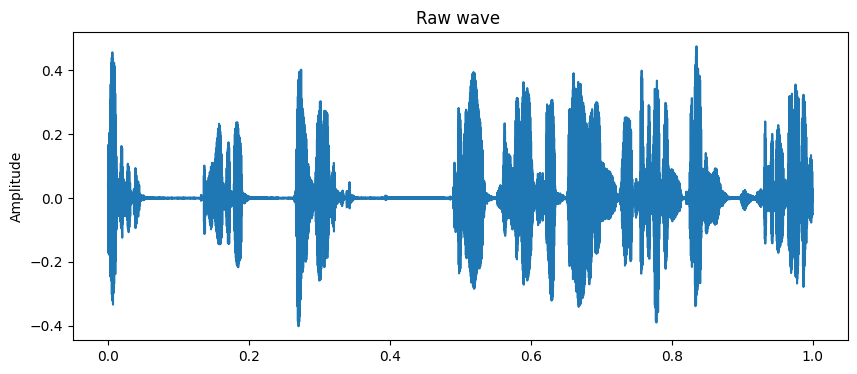

In [3]:
def plot_time_series(data):
    fig = plt.figure(figsize=(10, 4))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

data, sr = librosa.load('input.wav', sr=22050)

print(data.shape)
plot_time_series(data) # 시간에 따른 소리 데이터의 변화를 그래프로 표시

## 1. Adding White Noise

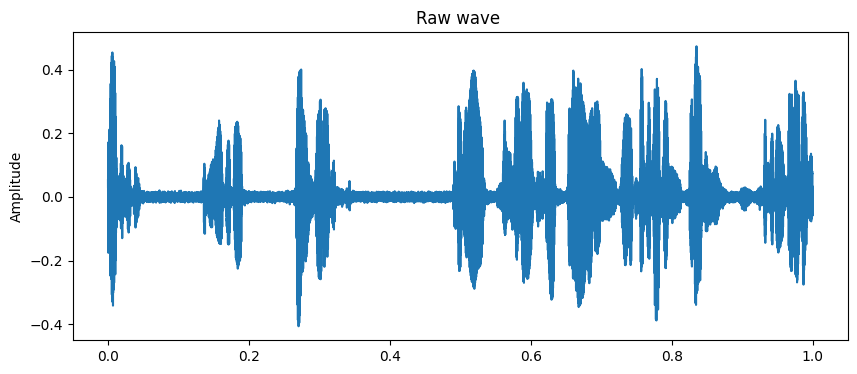

White Noise 저장 성공


array([0.03448812, 0.0516396 , 0.04611227, ..., 0.01943914, 0.01567049,
       0.        ], dtype=float32)

In [4]:
def adding_white_noise(data, sr=22050, noise_rate=0.005):
    # noise 방식으로 일반적으로 쓰는 잡음 끼게 하는 겁니다.
    wn = np.random.randn(len(data))
    data_wn = data + noise_rate*wn
    plot_time_series(data_wn)
    # librosa.output.write_wav 대신 soundfile 라이브러리의 write 함수를 사용합니다.
    sf.write('white_noise.wav', data_wn, sr)  # 수정된 부분
    print('White Noise 저장 성공')
    
    return data

adding_white_noise(data)

## 1-1. Adding Partial_White_Noise

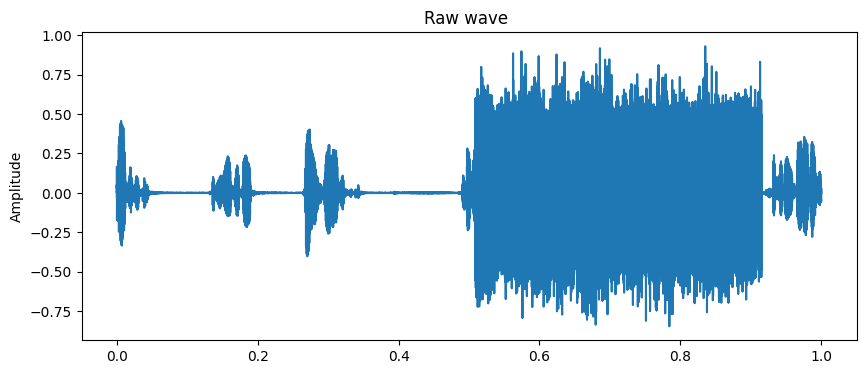

부분적으로 White Noise 삽입 성공


array([0.03448812, 0.0516396 , 0.04611227, ..., 0.01943914, 0.01567049,
       0.        ], dtype=float32)

In [5]:
def adding_white_noise_partially(data, start_time, end_time, sr=22050, noise_rate=0.2): # noise_rate 크기 조정 -> 노이즈 소리 조정
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    
    # 오직 특정 구간에만 노이즈를 추가.
    data_with_noise = np.copy(data)
    data_with_noise[start_sample:end_sample] += noise_rate * np.random.randn(end_sample - start_sample)
    
    plot_time_series(data_with_noise)
    sf.write('partial_white_noise.wav', data_with_noise, sr)
    print('부분적으로 White Noise 삽입 성공')
    
    return data_with_noise

# 예를 들어, 오디오의 5초부터 9초까지의 구간에 노이즈를 추가하고 싶다면:
adding_white_noise_partially(data, 5, 9) # 주어진 구간 (시작 시간부터 끝 시간까지)에 대해 주어진 비율의 백색 소음을 추가

## 1-2_1. similarity(그래프 동시에 시각화)

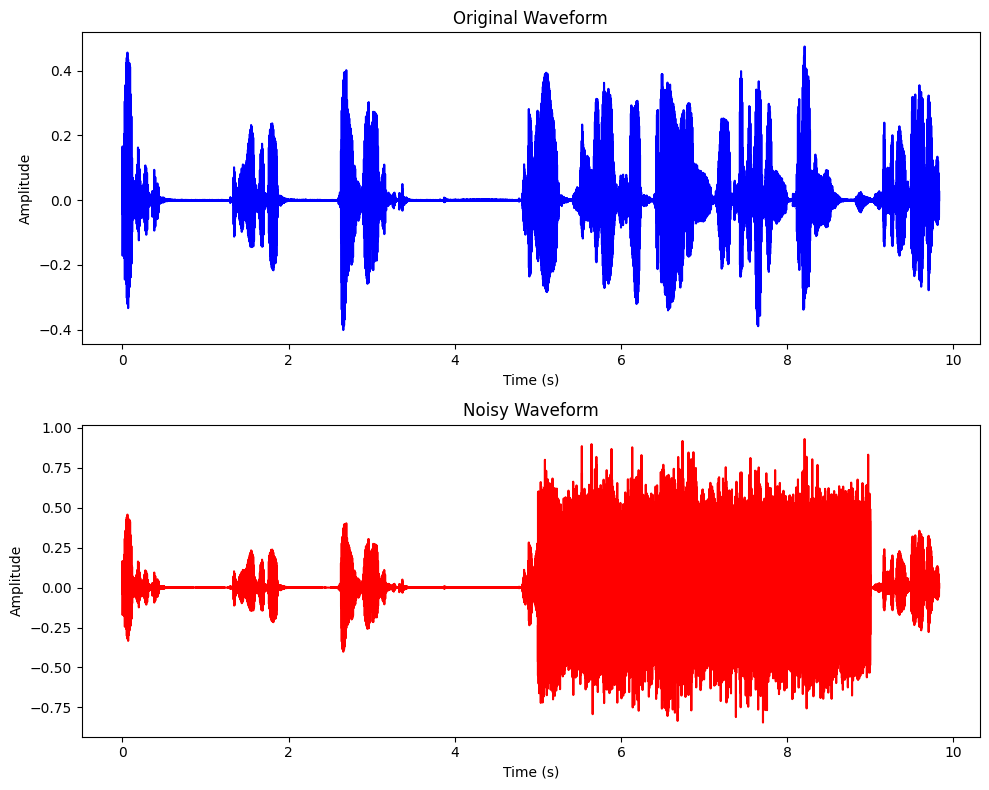

In [6]:
def plot_comparison(original_data, noisy_data):
    time = np.linspace(0, len(original_data) / sr, num=len(original_data))
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, original_data, color='blue')
    plt.title('Original Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.plot(time, noisy_data, color='red')
    plt.title('Noisy Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

# 원본 오디오 로드
original_data, sr = librosa.load('input.wav', sr=22050)

# 백색 소음이 추가된 오디오 로드
noisy_data, sr = librosa.load('partial_white_noise.wav', sr=22050)

# 원본 오디오와 백색 소음이 추가된 오디오의 그래프 비교
plot_comparison(original_data, noisy_data)

## 1-2_2. similarity(피어슨 상관 계수, 평균 제곱 오차)
1. 두 오디오 시그널의 피어슨 상관 계수를 계산하여 유사성을 측정.
- 두 신호가 유사할수록 상관 계수는 1에 가까워짐
2. 오디오 신호 간의 평균 제곱 오차(Mean Squared Error, MSE)를 계산.
- MSE는 두 신호 간의 차이를 측정하며, 값이 작을수록 두 신호가 유사함을 나타냅

In [7]:
def calculate_similarity(original_data, noisy_data): # 두 변수 간의 선형 상관 관계의 강도와 방향을 측정
    correlation_coefficient = np.corrcoef(original_data, noisy_data)[0, 1]
    return correlation_coefficient

similarity = calculate_similarity(original_data, noisy_data) # -1에서 1 사이의 범위를 가지며, 1에 가까울수록 두 신호가 유사함을 의미
print("두 오디오의 유사성 (피어슨 상관 계수):", similarity)

def calculate_mse(original_data, noisy_data):
    mse = np.mean((original_data - noisy_data) ** 2)
    return mse

mse_value = calculate_mse(original_data, noisy_data) # 오디오의 진폭 단위(보통 -1에서 1 사이)의 제곱 단위로 표현, 제곱을 평균화한 값이기 때문에 항상 0 이상의 값
print("두 오디오의 유사성 (평균 제곱 오차):", mse_value)

두 오디오의 유사성 (피어슨 상관 계수): 0.3909605581329221
두 오디오의 유사성 (평균 제곱 오차): 0.016229745


## 1-2_2. 백분율로 표시(피어슨 상관 계수, 평균 제곱 오차)

In [12]:
def calculate_correlation_similarity(original_data, noisy_data):
    # 피어슨 상관 계수를 이용하여 유사성 측정
    correlation_coefficient = np.corrcoef(original_data, noisy_data)[0, 1]
    # 피어슨 상관 계수 값을 0에서 100 사이의 백분율 값으로 변환
    correlation_similarity = ((correlation_coefficient + 1) / 2) * 100
    return correlation_similarity

def calculate_mse_similarity(original_data, noisy_data):
    # 평균 제곱 오차를 이용하여 유사성 측정
    mse = np.mean((original_data - noisy_data) ** 2)
    # 평균 제곱 오차 값을 0에서 100 사이의 백분율 값으로 변환
    mse_similarity = ((1 - mse) / 2) * 100 # 값이 작을수록 유사성이 높으므로, 1에서 뺀 뒤 100을 곱하여 백분율로 변환
    return mse_similarity

# 각각의 유사성 지표 계산
correlation_similarity = calculate_correlation_similarity(original_data, noisy_data)
mse_similarity = calculate_mse_similarity(original_data, noisy_data)

# 각각의 유사성 지표 출력
print("피어슨 상관 계수를 이용한 유사성 (백분율): {:.2f}%".format(correlation_similarity))
print("평균 제곱 오차를 이용한 유사성 (백분율): {:.2f}%".format(mse_similarity))



피어슨 상관 계수를 이용한 유사성 (백분율): 69.55%
평균 제곱 오차를 이용한 유사성 (백분율): 49.19%


In [13]:
def calculate_similarity_percentage(original_data, noisy_data):
    # 피어슨 상관 계수를 이용하여 유사성 측정
    correlation_coefficient = np.corrcoef(original_data, noisy_data)[0, 1]
    # 평균 제곱 오차를 이용하여 유사성 측정
    mse = np.mean((original_data - noisy_data) ** 2)
    
    # 피어슨 상관 계수와 평균 제곱 오차 값을 기준으로 유사성을 백분율로 계산
    similarity_percentage = ((correlation_coefficient + 1) / 2) * 100  # -1에서 1 사이의 값을 0에서 100 사이의 백분율로 변환
    mse_percentage = ((1 - mse) / 2) * 100  # 값이 작을수록 유사성이 높으므로, 1에서 뺀 뒤 100을 곱하여 백분율로 변환
    
    # 두 지표의 평균을 사용하여 최종 유사성 백분율 계산
    overall_similarity_percentage = (similarity_percentage + mse_percentage) / 2
    
    return overall_similarity_percentage

# 원본과 노이즈 섞인 오디오의 유사성 백분율 계산
similarity_percentage = calculate_similarity_percentage(original_data, noisy_data)
print("그래프 유사도 (백분율): {:.2f}%".format(similarity_percentage))


그래프 유사도 (백분율): 59.37%


## 1-2_3. similarity(Dynamic Time Warping(DTW))
- 두 시계열 데이터 간의 최적 매칭 경로를 찾아 유사성을 측정하는 방법

In [9]:
# 두 오디오 파일 로드
original_data, sr = librosa.load('input.wav', sr=22050)
noisy_data, sr = librosa.load('partial_white_noise.wav', sr=22050)

# DTW를 계산하여 두 오디오 데이터 간의 거리를 측정, 값이 작을수록 두 오디오 신호가 유사
# 두 시계열 데이터 간의 거리이기 때문에 항상 0 이상의 값
distance, path = fastdtw(original_data, noisy_data)

print("DTW 거리:", distance)


DTW 거리: 16136.372919526988


## 1-2_3. 백분율 표시 (DTW)
- DTW 거리는 두 오디오 신호 간의 유사성을 측정하는 데 사용되지만, 그 자체로는 유사성을 백분율로 나타내는 것이 불가능
- 이유는 DTW 거리의 범위가 항상 0 이상의 값이기 때문

## 1-2_4. similarity(크로스 상관 함수(Cross-correlation function))

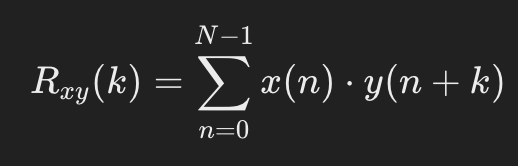
##### R_xy(k) = ∑_(n=0)^(N-1)x(n) * y(n+k)
- x(n), y(n)는 두 시계열 데이터, N은 시계열 길이. k는 한 시계열 데이터가 다른 시계열 데이터에 대해 얼마나 지연되는지 나타내는 매개 변수
- k 값이 양수 -> y(n)가 x(n)에 비해 시간적으로 지연
- k 값이 음수 -> x(n)가 y(n)에 비해 시간적으로 지연
- 크로수 상관 함수의 피크가 높고 두 데이터 간의 시간 지연이 작을수록 두 데이터가 유사

1. 피크의 위치: 피크의 위치는 두 데이터 간의 시간적인 관련성을 나타냄. 피크의 위치가 0에 가까울수록 두 데이터가 동시에 변화.
- 양의 값은 두 번째 데이터가 먼저 변화하는 것, 음의 값은 첫 번째 데이터가 먼저 변화하는 것.

2. 피크의 높이: 피크의 높이는 두 데이터 간의 상관 관계의 강도. 높은 피크는 강한 상관 관계, 낮은 피크는 약한 상관 관계.

3. 피크의 폭: 피크의 폭은 두 데이터 간의 상관 관계의 지속 시간. 넓은 피크는 상관 관계가 오랫동안 지속되는 것, 좁은 피크는 상관 관계가 짧은 시간 동안에만 나타나는 것.




## 1-2_4. 백분율 표시 (크로스 상관 함수)

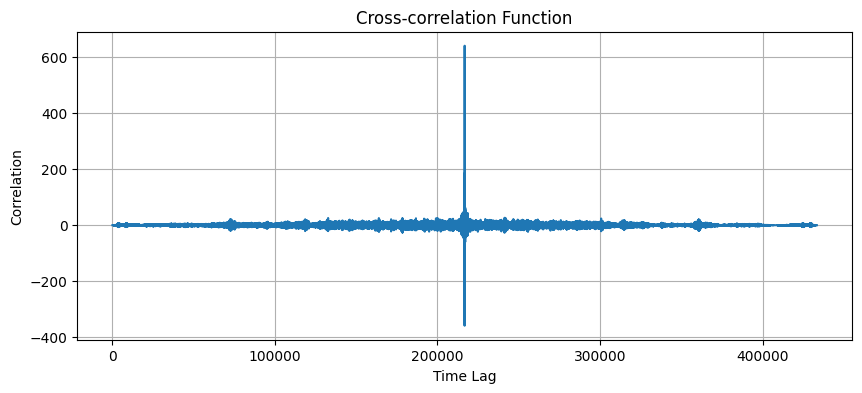

In [10]:
# 크로스 상관 함수를 통해 두 시계열 데이터의 유사성과 시간적 관련성을 파악
def calculate_cross_correlation(original_data, noisy_data):
    cross_correlation = np.correlate(original_data, noisy_data, mode='full')
    return cross_correlation

cross_correlation = calculate_cross_correlation(original_data, noisy_data)

# 크로스 상관 함수를 시각화
plt.figure(figsize=(10, 4))
plt.plot(cross_correlation)
plt.title('Cross-correlation Function')
plt.xlabel('Time Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

## 1-2_4. 백분율 표시 (크로스 상관 함수)
- 크로스 상관 함수의 출력 자체는 특정한 범위나 척도를 갖지 않으며, 보통 시간 지연에 따른 상관 값의 변화를 나타내는 그래프. 직접적으로 백분율로 유사성을 표현하기는 어려움
- 유사성 백분율이 100%를 초과할 수 있음. 이는 피크 값이 주변 값보다 훨씬 높을 때 발생
- 그래서 우선 유사성 백분율이 100%를 초과하는 경우를 고려하여, 100%를 초과할 경우에는 100%로 제한

In [18]:
def interpret_cross_correlation(cross_correlation):
    # 크로스 상관 함수에서 가장 높은 피크의 위치를 찾습니다.
    peak_index = np.argmax(cross_correlation)
    # 가장 높은 피크의 값
    peak_value = cross_correlation[peak_index]

    # 피크 주변의 값들
    surrounding_values = cross_correlation[peak_index - 5: peak_index + 5]  # 예: 피크 주변에서 5개의 값만 고려

    # 유사성을 측정하기 위해 피크와 주변 값들의 평균을 계산합니다.
    mean_value = np.mean(surrounding_values)

    # 유사성을 백분율로 표현합니다. 값이 클수록 유사성이 높습니다.
    similarity_percentage = (peak_value / mean_value) * 100

    # 유사성 백분율이 100%를 초과하는 경우 100%로 제한합니다.
    similarity_percentage = min(similarity_percentage, 100)

    return similarity_percentage

# 크로스 상관 함수 해석하여 유사성 백분율로 표현
similarity_percentage = interpret_cross_correlation(cross_correlation)
print("유사성 (백분율): {:.2f}%".format(similarity_percentage))


# 기존 코드 백분율 118%
# def interpret_cross_correlation(cross_correlation):
#     # 크로스 상관 함수에서 가장 높은 피크의 위치를 찾습니다.
#     peak_index = np.argmax(cross_correlation)
#     # 가장 높은 피크의 값
#     peak_value = cross_correlation[peak_index]

#     # 피크 주변의 값들
#     surrounding_values = cross_correlation[peak_index - 5 : peak_index + 5]  # 예: 피크 주변에서 5개의 값만 고려

#     # 유사성을 측정하기 위해 피크와 주변 값들의 평균을 계산합니다.
#     mean_value = np.mean(surrounding_values)

#     # 유사성을 백분율로 표현합니다. 값이 클수록 유사성이 높습니다.
#     similarity_percentage = (peak_value / mean_value) * 100

#     return similarity_percentage

# # 크로스 상관 함수 해석하여 유사성 백분율로 표현
# similarity_percentage = interpret_cross_correlation(cross_correlation)
# print("유사성 (백분율): {:.2f}%".format(similarity_percentage))


유사성 (백분율): 100.00%


## 1-2_5. similarity(특징 추출 및 유사성 측정)
1. 특징 추출: 각 오디오 신호에서 음성 특징을 추출합니다. 일반적으로 MFCC(Mel-Frequency Cepstral Coefficients)와 같은 특징이 사용
2. 특징 유사성 측정: 추출된 특징을 사용하여 두 오디오 신호 간의 유사성을 측정 ex) 유클리디안 거리, 코사인 유사도, 맨하탄 거리 ...

- 유클라디안 거리: 두 점 사이의 직선 거리, 항상 0 이상의 값을 가지며, 거리가 클수록 두 점 사이의 차이가 큼. 최솟값: 0
- 코사인 유사도: 두 벡터 간의 각도에 대한 코사인 값을 사용, -1 ~ 1, 최댓값: 1(동일한 방향) 최솟값: -1(반대 방향) 0: 직교
- 맨하탄 거리: 두 점 사이의 좌표 간 차이의 절대값의 합, 항상 0 이상의 값, 최솟값: 0

In [11]:
# 두 오디오 파일 로드
original_data, sr = librosa.load('input.wav', sr=22050)
noisy_data, sr = librosa.load('partial_white_noise.wav', sr=22050)

# MFCC 특징 추출
original_mfcc = librosa.feature.mfcc(y=original_data, sr=sr)
noisy_mfcc = librosa.feature.mfcc(y=noisy_data, sr=sr)

# 코사인 유사도를 사용하여 두 오디오 간의 특징 유사성 측정
similarity_matrix = cosine_similarity(original_mfcc.T, noisy_mfcc.T)
average_similarity = similarity_matrix.mean()

# 유클리디안 거리를 사용하여 두 오디오 간의 특징 유사성 측정
distances = euclidean_distances(original_mfcc.T, noisy_mfcc.T)
average_distance = distances.mean()

# 맨하탄 거리를 사용하여 두 오디오 간의 특징 유사성 측정
manhattan_distances = manhattan_distances(original_mfcc.T, noisy_mfcc.T)
average_manhattan_distance = manhattan_distances.mean()


print("두 오디오 간의 평균 특징 유사성:", average_similarity)
print("두 오디오 간의 평균 유클리디안 거리:", average_distance)
print("두 오디오 간의 평균 맨하탄 거리:", average_manhattan_distance)


두 오디오 간의 평균 특징 유사성: 0.20439138
두 오디오 간의 평균 유클리디안 거리: 307.12305
두 오디오 간의 평균 맨하탄 거리: 588.4002978115961


## 1-2_5. 백분율 표시(특징 추출 및 유사성 측정)

In [21]:
# 코사인 유사도를 백분율로 변환하는 함수 정의
def convert_similarity_to_percentage(similarity):
    # 코사인 유사도가 클수록 유사성이 높으므로 1을 더하고 2로 나눈 후 100을 곱합니다.
    similarity_percentage = (similarity + 1) / 2 * 100
    return similarity_percentage

# 거리 값을 백분율로 변환하는 함수 정의
def convert_distance_to_percentage(distance):
    # 거리 값이 작을수록 유사성이 높으므로 최소 거리를 0%, 최대 거리를 100%로 설정합니다.
    min_distance = 0
    max_distance = 1000  # 예시로 임의의 최대 거리를 설정합니다.

    # 거리 값을 0과 100 사이의 백분율 값으로 변환합니다.
    percentage = 100 - (distance - min_distance) / (max_distance - min_distance) * 100
    return percentage

# 코사인 유사도를 백분율로 변환
similarity_percentage = convert_similarity_to_percentage(average_similarity)
print("코사인 유사도를 이용한 평균 특징 유사성 (백분율): {:.2f}%".format(similarity_percentage))

# 평균 유클리디안 거리를 백분율로 변환
distance_percentage = convert_distance_to_percentage(307.12305)
print("평균 유클리디안 거리 (백분율): {:.2f}%".format(distance_percentage))

# 평균 맨하탄 거리를 백분율로 변환
manhattan_distance_percentage = convert_distance_to_percentage(588.4002978115961)
print("평균 맨하탄 거리 (백분율): {:.2f}%".format(manhattan_distance_percentage))


코사인 유사도를 이용한 평균 특징 유사성 (백분율): 60.22%
평균 유클리디안 거리 (백분율): 69.29%
평균 맨하탄 거리 (백분율): 41.16%


참고: https://github.com/smothly/High_Perfomance_Python/tree/master